# Chapter 11: Training Deep Neural Nets - Part 2

In [2]:
#set up libs and data from first notebook!
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


# Reusing Pretrained Layers
It is generally not a good idea to train a very large DNN from scratch: **instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then just REUSE THE LOWER LAYERS of this network: this is called transfer learning. This will not only speed up training considerably, but will also require much less training data.**

For example, suppose that you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects. You now want to train a DNN to classify specific types of vehicles. These tasks are very similar, so you should try to reuse parts of the first network.

**NOTE: If the input pictures of your new task don’t have the same size as the ones used in the original task, you will have to add a preprocessing step to resize them to the size expected by the original model. More generally, transfer learning will work only well if the inputs have similar low-level features.**

![](pictures/homl_ch11_reuselayers.jpg)



## Reusing a TensorFlow Model

In general, you will want to reuse only PART of the original model. **A SIMPLE SOLUTION IS TO CONFIGURE THE SAVER TO RESTORE ONLY A SUBSET OF THE VARIABLES FROM THE ORIGINAL MODEL**

First you need to **load the graph's structure. The import_meta_graph() function does just that,** loading the graph's operations into the default graph, and returning a Saver that you can then use to restore the model's state. Note that by default, a Saver saves the structure of the graph into a .meta file, so that's the file you should load:



In [3]:
reset_graph()
saver = tf.train.import_meta_graph("./elu_nn_model2.ckpt.meta") #batch normalization model
#saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta") #gradient clipper model

#Next you need to get a handle on all the operations you will need for training.
#If you don't know structure, you can list all the operations:
for op in tf.get_default_graph().get_operations():
    print(op.name)


X
y
training/input
training
hidden1/kernel/Initializer/truncated_normal/shape
hidden1/kernel/Initializer/truncated_normal/mean
hidden1/kernel/Initializer/truncated_normal/stddev
hidden1/kernel/Initializer/truncated_normal/TruncatedNormal
hidden1/kernel/Initializer/truncated_normal/mul
hidden1/kernel/Initializer/truncated_normal
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
batch_normalization/beta/Initializer/zeros
batch_normalization/beta
batch_normalization/beta/Assign
batch_normalization/beta/read
batch_normalization/gamma/Initializer/ones
batch_normalization/gamma
batch_normalization/gamma/Assign
batch_normalization/gamma/read
batch_normalization/moving_mean/Initializer/zeros
batch_normalization/moving_mean
batch_normalization/moving_mean/Assign
batch_normalization/moving_mean/read
batch_normalization/moving_variance/Initializer/ones
batch_normalizatio

train/gradients/dnn/batch_normalization_2/moments/variance_grad/tuple/control_dependency_1
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/Shape
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/Size
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/add
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/mod
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/Shape_1
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/range/start
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/range/delta
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/range
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/Fill/value
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/Fill
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/DynamicStitch
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/Maximum/y
train/gradients/dnn/batch_normalization_2/moments/Mean_1_grad/Maximu

Oops, that's a lot of operations! **It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a FileWriter to save the graph and then visualize it in TensorBoard):**



In [4]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [5]:
show_graph(tf.get_default_graph())

## Once you know which operations you need, you can get a handle on them using the graph's get_operation_by_name() or get_tensor_by_name() methods:

In [21]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("train/GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [22]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

This way people who reuse your model will be able to simply write:

In [23]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

## Lets try to restore and test a model for realsies!!!

In [18]:
reset_graph()

#first you must import the meta_graph or the graph architecture!
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta") # original gradient clipper model from pt 1

#Get a handle on all the operations you will need for training.
[op.name for op in tf.get_default_graph().get_operations()]

['X',
 'y',
 'hidden1/kernel/Initializer/random_uniform/shape',
 'hidden1/kernel/Initializer/random_uniform/min',
 'hidden1/kernel/Initializer/random_uniform/max',
 'hidden1/kernel/Initializer/random_uniform/RandomUniform',
 'hidden1/kernel/Initializer/random_uniform/sub',
 'hidden1/kernel/Initializer/random_uniform/mul',
 'hidden1/kernel/Initializer/random_uniform',
 'hidden1/kernel',
 'hidden1/kernel/Assign',
 'hidden1/kernel/read',
 'hidden1/bias/Initializer/zeros',
 'hidden1/bias',
 'hidden1/bias/Assign',
 'hidden1/bias/read',
 'dnn/hidden1/MatMul',
 'dnn/hidden1/BiasAdd',
 'dnn/hidden1/Relu',
 'hidden2/kernel/Initializer/random_uniform/shape',
 'hidden2/kernel/Initializer/random_uniform/min',
 'hidden2/kernel/Initializer/random_uniform/max',
 'hidden2/kernel/Initializer/random_uniform/RandomUniform',
 'hidden2/kernel/Initializer/random_uniform/sub',
 'hidden2/kernel/Initializer/random_uniform/mul',
 'hidden2/kernel/Initializer/random_uniform',
 'hidden2/kernel',
 'hidden2/kernel/A

In [19]:
#Load all of the operations you will need for retraining.
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
m1_accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
m1_loss = tf.get_default_graph().get_tensor_by_name("loss/loss:0")
m1_training_op = tf.get_default_graph().get_operation_by_name("train/GradientDescent")

In [21]:
#rerun the model
n_epochs = 5
batch_size = 200
with tf.Session() as sess:
    #retore orignal batch_normalization model from part 1
    saver.restore(sess,"./my_model_final.ckpt")
    
    #rerun the model!
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(m1_training_op, feed_dict={X: X_batch, y: y_batch})
        feed_dict_vars = {X: mnist.test.images, y: mnist.test.labels}
        accuracy_val, loss_val = sess.run([m1_accuracy, m1_loss], feed_dict=feed_dict_vars)
        print("Epoch {0}: loss {1}, accuracy: {2}".format(epoch+1,loss_val,accuracy_val))

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
Epoch 1: loss 0.1925574243068695, accuracy: 0.9412999749183655
Epoch 2: loss 0.1865510791540146, accuracy: 0.9434999823570251
Epoch 3: loss 0.18017424643039703, accuracy: 0.9453999996185303
Epoch 4: loss 0.1682170182466507, accuracy: 0.9490000009536743
Epoch 5: loss 0.1676151603460312, accuracy: 0.9496999979019165


### In general you will want to reuse the lower layers. 
If you using import_meta_graph() it will load THE WHOLE GRAPH but you can simply ignore the parts you do not need. 

In this example, we will:
- add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th layer).
- build a new output layer, the loss for this new output, and a new optimizer to minimize it.
- we will also need another save to save the whole graph (containing both the entire old graph plus the new operations)
- we will also need an initialization operations to initialization operation to initiatlize all the new variables

In [130]:
#------------------------------------------------------------#
#################### CONSTRUCITON PHASE ######################
#------------------------------------------------------------#

reset_graph()
n_hidden4 = 20 # new layer
n_outputs = 10 # new output layer
learning_rate = 0.01

#load old model as default graph
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta") # original gradient clipper model from pt 1

#get old model variables
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

#load final step in 3rd hidden layer (so this would be the output of the relu activation)
#NOTE: He uses 'dnn/hidden4/Relu' on his github... and I'm not sure why. Lets go with this for now!
hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

#SET NEW LAYERS WOOOOT
new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation = tf.nn.relu, name='new_hidden4')
new_logits = tf.layers.dense(new_hidden4, n_outputs, name='new_outputs')

#set new loss function with new_logits
with tf.name_scope('new_loss'):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(cross_entropy, name='loss')

#set new evaluation operation
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy_val')
    
#set new training operations
with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [129]:
tf.trainable_variables()

[<tf.Variable 'hidden1/kernel:0' shape=(784, 300) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(300,) dtype=float32_ref>,
 <tf.Variable 'hidden2/kernel:0' shape=(300, 50) dtype=float32_ref>,
 <tf.Variable 'hidden2/bias:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'hidden3/kernel:0' shape=(50, 50) dtype=float32_ref>,
 <tf.Variable 'hidden3/bias:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'hidden4/kernel:0' shape=(50, 50) dtype=float32_ref>,
 <tf.Variable 'hidden4/bias:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'hidden5/kernel:0' shape=(50, 50) dtype=float32_ref>,
 <tf.Variable 'hidden5/bias:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'outputs/kernel:0' shape=(50, 10) dtype=float32_ref>,
 <tf.Variable 'outputs/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'new_hidden4/kernel:0' shape=(50, 20) dtype=float32_ref>,
 <tf.Variable 'new_hidden4/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'new_outputs/kernel:0' shape=(20, 10) dtype=float32_ref>,

#### Take a look at the weights of hidden3 from the old model JUST FROM LOADING THE META DATA

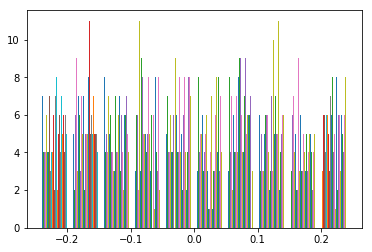

In [137]:
hidden3_weights_old = tf.get_default_graph().get_tensor_by_name("hidden3/kernel:0")

with tf.Session() as sess:
    init.run()
    test = hidden3_weights_old.eval()
    
import matplotlib.pyplot as plt
plt.hist(test)
plt.show()

#### Now look at the weights from hidden3 AFTER LOADING THE FULL MODEL

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


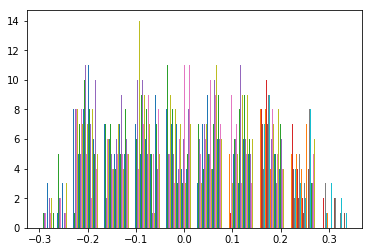

In [138]:
hidden3_weights_old = tf.get_default_graph().get_tensor_by_name("hidden3/kernel:0")

with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")
    test = hidden3_weights_old.eval()
    
import matplotlib.pyplot as plt
plt.hist(test)
plt.show()


In [88]:
[var.name for var in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'hidden3/kernel:0',
 'hidden3/bias:0',
 'hidden4/kernel:0',
 'hidden4/bias:0',
 'hidden5/kernel:0',
 'hidden5/bias:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'new_hidden4/kernel:0',
 'new_hidden4/bias:0',
 'new_outputs/kernel:0',
 'new_outputs/bias:0']

# SOOO I'm not sure. But I think that when you load the meta data, you don't get the actual weights. Let's do some reasearch:

![](pictures/homl_ch11_spongebob.jpg)

### OK! So take a look at this website:
http://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/

### a) Meta graph:
This is a protocol buffer which saves the complete Tensorflow graph; i.e. all variables, operations, collections etc. This file has .meta extension.

### b) Checkpoint file:
This is a binary file which contains **all the values of the weights, biases, gradients and all the other variables saved**. This file has an extension .ckpt. However, Tensorflow has changed this from version 0.11. Now, instead of single .ckpt file, we have two files:



# USING THE SAVER() CLASS
So, in Tensorflow, you want to save the graph and values of all the parameters for which we shall be creating an instance of tf.train.Saver() class.

    saver = tf.train.Saver()
    
Remember that Tensorflow variables are only alive inside a session. So, you have to save the model inside a session by calling save method on saver object you just created.

    saver.save(sess, 'my-model')
    
If we are saving the model after the 1000 iteration:
    
    saver.save(sess, 'my-model', global_step=1000)
    
Let’s say we are saving our model after every 1000 iterations, so .meta file is created the first time(on 1000th iteration) and we don’t need to recreate the .meta file each time. We only save the model for further iterations, as the graph will not change. Hence, when we don’t want to write the meta-graph we use this:
    
    saver.save(sess, 'my-model', global_step=step,write_meta_graph=False)   
    
If you want to keep only 4 latest models and want to save one model after every 2 hours during training you can use max_to_keep and keep_checkpoint_every_n_hours like this.
 
    #saves a model every 2 hours and maximum 4 latest models are saved.
    saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=2)
    
**NOTE: if we don’t specify anything in the tf.train.Saver(), it saves ALL the variables. BUT We can specify the variables/collections we want to save if we dont want them all:

    import tensorflow as tf
    w1 = tf.Variable(tf.random_normal(shape=[2]), name='w1')
    w2 = tf.Variable(tf.random_normal(shape=[5]), name='w2')
    saver = tf.train.Saver([w1,w2])

# IMPORTING A PRETRAINED MODEL

### a) Create the network:
We have saved the network in .meta file which we can use to recreate the network using tf.train.import() function like this: 
        
        saver = tf.train.import_meta_graph('my_test_model-1000.meta')

##### Remember, import_meta_graph appends the network defined in .meta file to the current graph. So, this will create the graph/network for you but we still need to load the value of the parameters that we had trained on this graph.

### b) Load the parameters:
We can restore the parameters of the network by calling restore on this saver

    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('my_test_model-1000.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))

 After this, the value of tensors like w1 and w2 has been restored and can be accessed:

    with tf.Session() as sess:    
        saver = tf.train.import_meta_graph('my-model-1000.meta')
        saver.restore(sess,tf.train.latest_checkpoint('./'))
        print(sess.run('w1:0'))
    
    ##Model has been restored. Above statement will print the saved value of w1.

In [86]:
len(test)

50

In [41]:
[v.name for v in tf.trainable_variables()]
    

['hidden1/kernel:0',
 'hidden1/bias:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'hidden3/kernel:0',
 'hidden3/bias:0',
 'hidden4/kernel:0',
 'hidden4/bias:0',
 'hidden5/kernel:0',
 'hidden5/bias:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'new_hidden4/kernel:0',
 'new_hidden4/bias:0',
 'new_outputs/kernel:0',
 'new_outputs/bias:0']

### Try without loading model: I think this just pulls in the meta data for 'hidden3', meaning that the actual  weights arent loaded!!! So i guess it does some default initialization itself?!?!

In [91]:
#TRY WITHOUT LOADING MODEL FIRST

#------------------------------------------------------------#
##################### EVALUATION PHASE #######################
#------------------------------------------------------------#
n_epochs = 3
batch_size = 200

with tf.Session() as sess:
    init.run()
    #saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)


0 Test accuracy: 0.6911
1 Test accuracy: 0.8493
2 Test accuracy: 0.8874


### Now try WITH the loaded model: ie pulling in the weights for hidden3.You should see a higher accuracy for the first epoch!

In [92]:
#TRY WITHOUT LOADING MODEL FIRST

#------------------------------------------------------------#
##################### EVALUATION PHASE #######################
#------------------------------------------------------------#
n_epochs = 3
batch_size = 200

with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.8822
1 Test accuracy: 0.9092
2 Test accuracy: 0.9203


# Reusing models from other frameworks!

In this example, for each variable we want to reuse:
- we find its initializer's ASSIGNMENT OPERATION: variable/kernel/Assign
- and we get its second input: variable/kernel/Assign.inputs[1[]: THIS IS THE INITIALIZATION VALUE
- When we run the initializer, we replace the initialization values with the ones we want, using a feed_dict

In [125]:
#first lets take a look at the operations to see if this makes sense!
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
graph = tf.get_default_graph()

#get the operations... You should see an /Assign operation!!!
for p in [op.name for op in graph.get_operations()]:
    print(p)

print("\nThese are the default operations created when you initialize a tf.layers.dense layer!")

X
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
hidden1/MatMul
hidden1/BiasAdd
hidden1/Relu

These are the default operations created when you initialize a tf.layers.dense layer!


In [96]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")

#extract initialization values
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

#run model
with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[  61.   83.  105.]]


### Note: the weights variable created by the tf.layers.dense() function is called "kernel" (instead of "weights" when using the tf.contrib.layers.fully_connected(), as in the book), and the biases variable is called bias instead of biases.

Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [140]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[  61.   83.  105.]]


### Note that we could also get a handle on the variables using get_collection() and specifying the scope:

In [141]:
#use global variables
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

In [146]:
#or use 'get_tensor_by_name()'... which is what I did earlier I think
print(tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0"))
print(tf.get_default_graph().get_tensor_by_name("hidden1/bias:0"))


Tensor("hidden1/kernel:0", shape=(2, 3), dtype=float32_ref)
Tensor("hidden1/bias:0", shape=(3,), dtype=float32_ref)


# Freezing the Lower Layers

**It is likely that the lower layers of the first DNN have learned to detect LOW-LEVEL FEATURES in pictures** that will be useful across both image classification tasks, so you can just reuse these layers as they are. It is generally a good idea to “freeze” their weights when training the new DNN: **if the lowerlayer weights are fixed, then the higher-layer weights will be easier to train (because they won’t have o learn a moving target).** To freeze the lower layers during training, the simplest solution is to give he optimizer the list of variables to train, excluding the variables from the lower layers:

In [160]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

#### Now, select which variables you want to freeze from the new model... And also select which variables you want to pull in from the old model... using the scope argument in tf.get_collections which takes in a regex pattern!!!

In [161]:
#use regex in 'scope' arg to select only hidden layers 3,4 and outpu!!!!
#get vars you want to freeze (from NEW MODEL)
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                               scope="hidden[34]|outputs")

#get vars you want to reuse (from OLD MODEL)
reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                              scope="hidden[123]")
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
reuse_vars_dict

{'hidden1/bias': <tf.Variable 'hidden1/bias:0' shape=(300,) dtype=float32_ref>,
 'hidden1/kernel': <tf.Variable 'hidden1/kernel:0' shape=(784, 300) dtype=float32_ref>,
 'hidden2/bias': <tf.Variable 'hidden2/bias:0' shape=(50,) dtype=float32_ref>,
 'hidden2/kernel': <tf.Variable 'hidden2/kernel:0' shape=(300, 50) dtype=float32_ref>,
 'hidden3/bias': <tf.Variable 'hidden3/bias:0' shape=(50,) dtype=float32_ref>,
 'hidden3/kernel': <tf.Variable 'hidden3/kernel:0' shape=(50, 50) dtype=float32_ref>}

In [162]:
#train train scope!
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    #set var_list to only the variabes you want to train!!!
    training_op = optimizer.minimize(loss, var_list=train_vars)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [163]:
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3
n_epochs = 10
with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.8965
1 Test accuracy: 0.9158
2 Test accuracy: 0.9223
3 Test accuracy: 0.926
4 Test accuracy: 0.9283
5 Test accuracy: 0.929
6 Test accuracy: 0.9322
7 Test accuracy: 0.9331
8 Test accuracy: 0.9338
9 Test accuracy: 0.9332


## Cachine Frozen Layers
Since the frozen layers won’t change, it is possible to cache the output of the topmost frozen layer for each training instance. Since training goes through the whole dataset many times, this will give you a huge speed boost as you will only need to go through the frozen layers once per training instance (instead of once per epoch).

In [165]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
#set reuse vars
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()


#run model
import numpy as np

n_batches = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: mnist.train.images})
    h2_cache_test = sess.run(hidden2, feed_dict={X: mnist.test.images}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(mnist.train.num_examples)
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(mnist.train.labels[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_test, # not shown
                                                y: mnist.test.labels})  # not shown
        print(epoch, "Test accuracy:", accuracy_val)                    # not shown

    save_path = saver.save(sess, "./my_new_model_final2.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.8881
1 Test accuracy: 0.9152
2 Test accuracy: 0.922
3 Test accuracy: 0.9254
4 Test accuracy: 0.9276
5 Test accuracy: 0.9302
6 Test accuracy: 0.9305
7 Test accuracy: 0.9307
8 Test accuracy: 0.9324
9 Test accuracy: 0.9323
